In [2]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.2 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [38]:
import os
from collections import defaultdict
import pandas as pd
import spacy
import torch
import numpy as np
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torch.utils.tensorboard import SummaryWriter
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

from tqdm  import tqdm, trange

## Vocabulary

In [3]:

class Vocabulary():
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold

    
    def __len__(self):
        return len(self.itos)


    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequency = {}
        idx = 4
        N = 50

        for sentence in sentence_list:
            for token in self.tokenizer_eng(sentence):

                frequency[token] = 1 + frequency.get(token, 0)

                if frequency[token] == self.freq_threshold:
                    self.stoi[token] = idx
                    self.itos[idx] = token
                    idx += 1
    
    def tokenize(self, text):
        token_sent = self.tokenizer_eng(text)

        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>']
                for token in token_sent
            ]
    def vocabulary_size(self):
        return len(self.stoi)

## Dataset

In [5]:
class FlickrDataset(Dataset):
    max_len = 45
    def __init__(self, root_dir, data_dict, vocabulary: Vocabulary, transform=None, train=True):
        self.root_dir = root_dir
        self.data_dict = data_dict
        self.transform = transform

        # get the image and caption
        self.train = train
        self.caption = []
        self.item = self.setup_item()

        # Create our own vocabulary
        self.vocabulary = vocabulary
        self.sos_token = torch.tensor([self.vocabulary.stoi['<SOS>']], dtype=torch.int64)
        self.eos_token = torch.tensor([self.vocabulary.stoi['<EOS>']], dtype=torch.int64)
        self.pad_token = torch.tensor([self.vocabulary.stoi['<PAD>']], dtype=torch.int64)
    
    def __len__(self):
        return len(self.item)
    
    def setup_item(self):
        item = []
        if self.train:
            for image_id, image_captions in self.data_dict.items():
                for caption in image_captions:
                    self.caption.append(caption)
                    item.append((image_id, caption))
        else:
            for image_id, image_captions in self.data_dict.items():
                self.caption.extend(image_captions)
                item.append((image_id, image_captions))
        return item


    def __getitem__(self, index):
        # get image
        image_path = os.path.join(self.root_dir, self.item[index][0])
        img = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # get caption
        caption = self.item[index][1]
        
        if self.train:
            cap_len = len(self.vocabulary.tokenize(caption))
            num_pad = FlickrDataset.max_len - cap_len - 2
            if num_pad < 0:
                raise ValueError("Caption too long")
            num_caption = torch.cat([
                        self.sos_token ,
                        torch.tensor(self.vocabulary.tokenize(caption), dtype=torch.int64),
                        self.eos_token,
                        torch.tensor([self.pad_token] * num_pad, dtype=torch.int64)], dim=0)
            return img, num_caption
        else:
            captions = torch.zeros(5, 45).to(torch.long)
            for idx, cap in enumerate(caption):
                cap_len = len(self.vocabulary.tokenize(cap))
                num_pad = FlickrDataset.max_len - cap_len - 2
                if num_pad < 0:
                    raise ValueError("Caption too long")
                num_caption =    torch.cat([
                        self.sos_token ,
                        torch.tensor(self.vocabulary.tokenize(cap), dtype=torch.int64),
                        self.eos_token,
                        torch.tensor([self.pad_token] * num_pad, dtype=torch.int64)], dim=0)

                captions[idx] = num_caption
            return img, torch.LongTensor(captions)


In [6]:
def get_loader(
    root_folder,
    data_dict,
    transform,
    vocabulary,
    batch_size=32,
    train=True,
    num_workers=1,
    shuffle=True,
    pin_memory=False,
):
    dataset = FlickrDataset(root_folder, data_dict=data_dict, transform=transform, train=train, vocabulary=vocabulary)

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
    )

    return loader, dataset

In [7]:

def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

### How dataset looks like

In [10]:
folder = "data/images/"

In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

In [9]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8508

In [12]:
train_dataset = FlickrDataset(root_dir=folder, data_dict=train_data,vocabulary=vocabulary,
                        transform=transform, train=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([45])
['<SOS>', 'a', 'brunette', 'and', 'blonde', 'girl', 'are', 'smiling', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


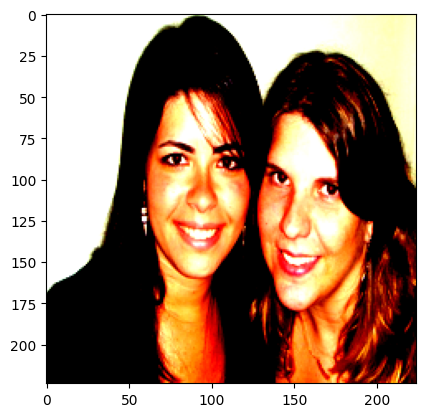

In [27]:
import random
random_index = random.randint(0, len(train_dataset) - 1)

# Get the random element
random_image, random_label = train_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)
plt.imshow(random_image.permute(1, 2,0))
print([vocabulary.itos[token] for token in random_label.tolist()])

In [28]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
for image, caption in train_loader:
    print(caption.shape)
    print(image.shape)
    index = random.randint(0, 31)
    first_image = image[index]
    print(first_image.shape)
    first_caption = caption[index]
    print(first_caption.shape)
    break

torch.Size([32, 45])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([45])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([5, 45])


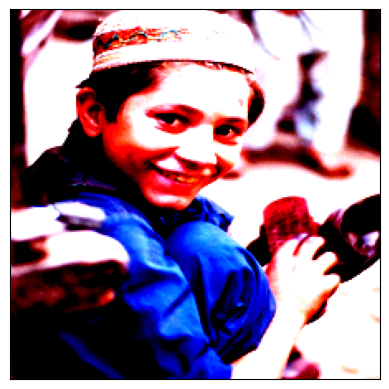

['<SOS>', 'a', 'boy', 'sitting', 'down', 'smiling', 'for', 'the', 'picture', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'child', 'holding', 'some', 'shoes', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'child', 'in', 'blue', 'and', 'wearing', 'a', 'hat', 'smiles', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PA

In [35]:
val_dataset = FlickrDataset(root_dir=folder, data_dict=val_data,vocabulary=vocabulary,
                        transform=transform, train=False)
random_index = random.randint(0, len(val_dataset) - 1)

# Get the random element
random_image, random_label = val_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)
plt.xticks([])
plt.yticks([])
plt.imshow(random_image.permute(1, 2,0))
plt.show()
print([vocabulary.itos[token] for token in random_label[0].tolist()])
print([vocabulary.itos[token] for token in random_label[1].tolist()])
print([vocabulary.itos[token] for token in random_label[2].tolist()])
print([vocabulary.itos[token] for token in random_label[3].tolist()])
print([vocabulary.itos[token] for token in random_label[4].tolist()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 5, 45])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([5, 45])


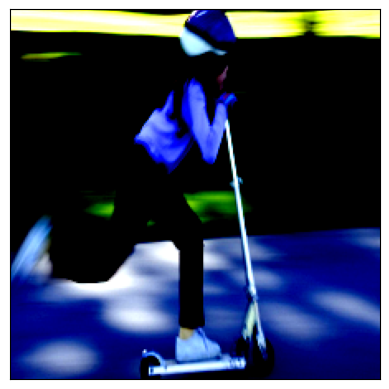

['<SOS>', 'a', 'girl', 'speeds', 'by', 'on', 'her', 'scooter', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'girl', 'wearing', 'a', 'helmet', 'rides', 'a', 'scooter', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'girl', 'with', 'a', 'purple', 'and', 'white', 'helmet', 'is', 'riding', 'on', 'a', 'scooter', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

In [36]:
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
for image, caption in val_loader:
    print(caption.shape)
    print(image.shape)
    index = random.randint(0, 31)
    random_image = image[index]
    print(random_image.shape)
    random_label = caption[index]
    print(random_label.shape)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(random_image.permute(1, 2,0))
    plt.show()
    print([vocabulary.itos[token] for token in random_label[0].tolist()])
    print([vocabulary.itos[token] for token in random_label[1].tolist()])
    print([vocabulary.itos[token] for token in random_label[2].tolist()])
    print([vocabulary.itos[token] for token in random_label[3].tolist()])
    print([vocabulary.itos[token] for token in random_label[4].tolist()])
    break

## Model Implementation

In [40]:
class PatchEmbedding(nn.Module):
    '''
    Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    '''
    def __init__(self, in_channels = 3, patch_size=16, embedding_dim=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim,
                                 kernel_size=patch_size, stride=patch_size, padding=0)
        
        self.flatten = nn.Flatten(start_dim=2)
    
    def forward(self, x):
        # input of shape (batch_size, color_channel, height, width)
        x = self.patcher(x) # (batch_size, embedding_dim, height//patch_size, width//patch_size)
        x = self.flatten(x) # (batch_size, embedding_dim, (height * width)//(patch_size)**2)
        return x.permute(0, 2, 1) #(batch_size,(height * width)//(patch_size)**2), embedding_dim)

In [41]:
class EncoderBlcok(nn.Module):
    '''
    Encoder block that returns a representation of the image patches.
    
    Args:
        embedding_dim (int): size of the embedding for each image patch. Defaults 768.
        num_heads (int): Number of head in the attention layer. Defaults 12.
        mlp_size (int): Size for the feed forward portion of the encoder. Defaults 3072.
        dropout (float): Amount of dropout in attention and mlp layer. Default 0.1
    '''
    def __init__(self, embeding_dim = 768, num_heads = 12, mlp_size= 3072, dropout=0.1):
        super().__init__()
        
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embeding_dim)
        self.attention = nn.MultiheadAttention(embed_dim=embeding_dim, num_heads=num_heads, dropout=dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embeding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embeding_dim, mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_size, embeding_dim),
            nn.Dropout(dropout)   
        )
    
    def forward(self, x):
        norm_x = self.layer_norm1(x)
        x = x + self.attention(norm_x, norm_x, norm_x, need_weights=False)[0]
        
        norm_x = self.layer_norm2(x)
        return x + self.mlp(norm_x)

In [42]:
class ViT(nn.Module):
    '''
    Creates a Vision Transformer architecture with ViT-Base hyperparameters by default with no classification token and layer.
    '''
    def __init__(self, img_size= 224, in_channels=3, patch_size=16, num_blocks = 12,
                 embed_dim = 768, mlp_size = 3072, num_heads = 12, dropout=0.1):
        super().__init__()
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        self.num_patches = (img_size // patch_size) ** 2
        
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        self.embed_dropout = nn.Dropout(dropout)
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embed_dim)
        
        self.transformer_encoder = nn.Sequential(*[EncoderBlcok(embeding_dim=embed_dim, num_heads=num_heads,
                                                                mlp_size=mlp_size, dropout=dropout) for _ in range(num_blocks)])
        
    def forward(self, x):
        # x is an image of shape (batch_size, color_chanel, height, width)
        x = self.patch_embedding(x) # -> (batch_size, embed_dim, num_patches)
        x = x + self.position_embedding
        x = self.embed_dropout(x)
        return self.transformer_encoder(x) # -> (batch_size, embed_dim, num_patches)
        
        

#### Decoder model (GPT-2 like model requires cross attention)

In [69]:
class DecoderBlock(nn.Module):
    
    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1, mlp_size=3072):
        super().__init__()
        self.mask_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout, batch_first=True)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        
        self.cross_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout, batch_first=True)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_size, embed_dim),
            nn.Dropout(dropout)
        )
        
    
    def forward(self, x, encoder_out, padding_mask):
        seq_len = x.shape[1]
        mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        att_x, _ = self.mask_attention(x, x, x, attn_mask=mask, need_weights=False, key_padding_mask=padding_mask)
        x = self.layer_norm1(x + att_x)
        att_x, _ = self.cross_attention(x, encoder_out, encoder_out, need_weights=False)
        x = self.layer_norm2(x + att_x)
        
        return self.mlp(x)
        

In [70]:
class GPT(nn.Module):
    
    def __init__(self, vocab_size, embed_dim = 768, mlp_size = 3072, max_seq_len=350, num_layers=12, num_heads=12, dropout=0.1, padding_idx=0):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_embedding = nn.Embedding(max_seq_len, embed_dim)
        
        self.transformer_decoder = nn.ModuleList(DecoderBlock(embed_dim, num_heads, dropout, mlp_size) for _ in range(num_layers))
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.padding_index = padding_idx
    
    def forward(self, x, encoder_out):
        # x of shape (batch_size, seq_len)
        _, seq_len = x.shape
        padding_key = (x == self.padding_index)
        pos = torch.arange(0, seq_len, dtype=torch.long, device=x.device)
        pos_embed = self.positional_embedding(pos) # shape (seq_len, n_emebd)
        token_embed = self.token_embedding(x) # output of shape (batch_size, seq_len, embed_dim)
        x = pos_embed + token_embed
        
        for decoder in self.transformer_decoder:
            x = decoder(x, encoder_out, padding_key)
            
        return self.fc_out(self.layer_norm(x))

In [ ]:
class Captioner(nn.Module):
    
    def __init__(self,vocab_size, max_seq_len, padding_idx, img_size= 224, in_channels=3, patch_size=16, num_blocks = 12,
                 embed_dim = 768, mlp_size = 3072, num_heads = 12, dropout=0.1):
        super().__init__()
        self.vit = ViT(
            img_size=img_size, in_channels=in_channels, patch_size=patch_size, embed_dim=embed_dim,
            num_blocks=num_blocks, mlp_size=mlp_size, num_heads=num_heads, dropout=dropout)
        
        self.gpt2 = GPT(
            vocab_size=vocab_size, max_seq_len=max_seq_len, padding_idx=padding_idx, embed_dim=embed_dim,
            mlp_size=mlp_size, num_layers=num_blocks, num_heads=num_heads, dropout=dropout)
        
    def forward(self, image, caption):
        encoder_out = self.vit(image)
        return self.gpt2(caption, encoder_out)

In [105]:
model = Captioner(vocab_size=vocabulary.vocabulary_size(), max_seq_len=45, padding_idx=vocabulary.stoi['<PAD>'],
                  num_blocks=4, num_heads=4, embed_dim=64, mlp_size=128)
for img, caption in train_loader:
    output = model(img[0].unsqueeze(0), caption[0].unsqueeze(0))
    print(output.shape)
    print(output.argmax(dim=-1))
    break

64
torch.Size([1, 45, 8508])
tensor([[8406, 6015, 3764, 3652, 5394, 8405, 7149, 6015, 4690, 6993, 2042, 3522,
         7636, 7104, 3830, 5396, 6783, 6989,  745, 7576, 5249, 2768, 3693, 3008,
         8081, 8405, 6015, 5160,  634, 8220, 5325, 3008, 5109, 5264, 6580, 4520,
         5325, 3033, 7540,  745, 8081, 8405, 6015, 2097, 2367]])


## Training

In [106]:
device = "cpu"
if torch.cuda.is_available():
    devcie = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

print(device)

mps


In [ ]:
embed_dim = 256
attention_dim = 256
decoder_dim = 256
encoder_dim = 512
vocab_size = vocabulary.vocabulary_size()
num_layers = 1
lr= 6e-4
num_epochs = 100
load_model = False
save_model = False
train_step = 0
val_step = 0
best_blue = 0
writer = SummaryWriter(log_dir="runs/flickr")

In [ ]:
model_path = "state_dict.pt"
model = model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocabulary.stoi["<PAD>"])
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=lr, weight_decay=1e-1, betas=(0.9, 0.95))

In [109]:
start_epoch = 0
if load_model:
    state_dict = torch.load(model_path)
    model = state_dict['model']
    optimizer = state_dict['optimizer']
    train_step = state_dict['train_step']
    val_step = state_dict['val_step']
    start_epoch = 1 + state_dict['epochs']

In [118]:
def train_epoch(train_loader, model: Captioner, device, criterion, optimizer, epoch, writer, global_step):
    losses = []

    model.train()
    batch_iterator = tqdm(enumerate(train_loader),total=len(train_loader) , desc=f"Training Processing Epoch: {epoch:02d}", leave=False)
    for idx, (imgs, caps) in batch_iterator:
        # move tensor to device if available
        imgs = imgs.to(device)
        caps = caps.to(device)

        optimizer.zero_grad()

        # forward prop
        
        predictions = model(imgs, caps[:,:-1])


        loss = criterion(predictions.view(-1, predictions.size(-1)), caps[:,1:].contiguous().view(-1))
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(captioner.parameters(), max_norm=1.)
        optimizer.step()
        
        batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
        writer.add_scalar("Training loss", loss.item(), global_step=global_step)
        global_step += 1

        # keep track of metrics
        losses.append(loss.item())
        

    print('Training Epoch #: [{0}]\t'
        'Loss: {loss:.4f}\t'.format(
                epoch, loss=np.mean(losses)))

    return global_step
    

In [119]:
def corpus_meteor(expected, predicted):
    meteor_score_sentences_list = list()
    [meteor_score_sentences_list.append(meteor_score(expect, predict)) for expect, predict in zip(expected, predicted)]
    meteor_score_res = np.mean(meteor_score_sentences_list)
    return meteor_score_res

In [ ]:
def val_epoch(model, device, validation_loader, vocabulary, criterion, global_step, writer, epoch, num_example=3):
    model.eval()
    epoch_loss = []
    references = []
    hypotheses = []
    ignore = {vocabulary.stoi['<SOS>'], vocabulary.stoi['<PAD>']}
    with torch.inference_mode():
        batch_iterator = tqdm(enumerate(validation_loader),total=len(validation_loader) ,desc=f"Evaluation Processing Epoch: {epoch:02d}", leave=False)
        for idx, (images, captions) in batch_iterator:
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            # forward prop
            sample_caption = captions[:,0,:].clone()
            predictions = model(images, sample_caption[:,:-1])

            loss = criterion(predictions.view(-1, predictions.size(-1)), sample_caption[:,1:].contiguous().view(-1))

            # keep track of metrics
            epoch_loss.append(loss.item())
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
            writer.add_scalar("Validation loss", loss.item(), global_step=global_step)
            global_step += 1
            
            # gather all references and hypothesis for blue and meteor score calculations
            # references
            for i in range(captions.shape[0]): #looping over the batch dimension
                caps = []
                for j in range(captions.shape[1]):
                    caps.append([ vocabulary.itos[token] for token in captions[i,j].tolist() if token not in ignore])
                references.append(caps)

            # Hypothesis
            predictions = torch.argmax(predictions, dim=-1)
            for prediction in predictions.tolist():
                hypotheses.append([vocabulary.itos[token] for token in prediction if token not in ignore])

        #print samples
        index = random.sample([i for i in range(len(hypotheses))], num_example)
        for idx in index:
            print("Here is the model prediction")
            print(hypotheses[idx])
            print("-"*100)
            print("Here are what the references look like")
            for i in range(5):
                print(references[idx][i])
            print("-"*100)        


        bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
        bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
        bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
        bleu_4 = corpus_bleu(references, hypotheses)
        meteor = corpus_meteor(references, hypotheses)
        
        writer.add_scalar('val_bleu1', bleu_1, epoch)
        writer.add_scalar('val_bleu2', bleu_2, epoch)
        writer.add_scalar('val_bleu3', bleu_3, epoch)
        writer.add_scalar('val_bleu4', bleu_4, epoch)
        writer.add_scalar('val_loss', np.mean(epoch_loss), epoch)
        writer.add_scalar('val_meteor', meteor, epoch)
        
        print(f'''Validation Epoch: {epoch}
              Val Loss: {np.mean(epoch_loss)}
              BLEU-1: {bleu_1}
              BLEU-2: {bleu_2}
              BLEU-3: {bleu_3}
              BLEU-4: {bleu_4}
              Meteor: {meteor}''')
    
    return bleu_4, global_step

In [122]:
for epoch in range(start_epoch, num_epochs):
    #train_loader, model: Captioner, device, criterion, optimizer, epoch, writer, global_ste
    train_step = train_epoch(train_loader=train_loader, model=model, device=device,
                            criterion=criterion, optimizer=optimizer, epoch=epoch, writer=writer, global_step=train_step)
    

    bleu_4, val_step = val_epoch(validation_loader=val_loader,
                                model=model, criterion=criterion, device=device, 
                                epoch=epoch, global_step=val_step, vocabulary=vocabulary, writer=writer)


    if save_model and best_blue <= bleu_4:
        print("saving most recent model")
        best_blue = bleu_4
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "train_step": train_step,
            "val_step": val_step,
            "epoch": start_epoch
        }
        torch.save(checkpoint, model_path)
    #break

Training Epoch #: [0]	Loss: 3.9454	


Validation Epoch: 0	
              BLEU-1: 0.1728339603571228	
              BLEU-2: 0.09744792779014352	
              BLEU-3: 0.0460264038486276	
              BLEU-4: 0.021902867890171627	
              Meteor: 0.22709861907501572


Training Epoch #: [1]	Loss: 3.7396	


Validation Epoch: 1	
              BLEU-1: 0.17792969846706722	
              BLEU-2: 0.10186607812370867	
              BLEU-3: 0.05034966776382412	
              BLEU-4: 0.025319806702122798	
              Meteor: 0.23541226018628295


Training Epoch #: [2]	Loss: 3.6147	


Validation Epoch: 2	
              BLEU-1: 0.1810039867482733	
              BLEU-2: 0.10467276193747238	
              BLEU-3: 0.0517435171489907	
              BLEU-4: 0.02551108976289882	
              Meteor: 0.24165774463207354


Training Epoch #: [3]	Loss: 3.5222	


Validation Epoch: 3	
              BLEU-1: 0.18225335504520188	
              BLEU-2: 0.10478384407460321	
              BLEU-3: 0.05244496602967468	
              BLEU-4: 0.025945059926378973	
              Meteor: 0.24350348952437756


KeyboardInterrupt: 